# Análise dos resultados DTW


Na base de dados temos:

217 Covers

221 Músicas

In [53]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from scipy.stats import ttest_ind

## Preparação dos dados

In [54]:
## Carrega as músicas e os covers nos arquivos json para análise
with open('df_results.json', 'r') as f:
    data = json.load(f)
df_results = pd.DataFrame(data)

with open('labels_final.json', 'r') as f:
    labels_final = json.load(f)

In [55]:
## @brief Função que avalia se uma música é um cover ou a música original
def check_cover(row):
    original = row['Original']
    cover = row['Cover']

    if original in labels_final:
        return cover in labels_final[original]
    else:
        return None

df_results['is_cover'] = df_results.apply(check_cover, axis=1)

## Gerando gráficos


Vamos plotar em gráficos as distancias DTW calculadas para "Covers Verdadeiros" e "Não Covers" para ter uma visão mais geral dos resultados obtidos.

In [56]:
df_valid = df_results[df_results['is_cover'].notnull()]

true_covers = df_valid[df_valid['is_cover'] == True]
false_covers = df_valid[df_valid['is_cover'] == False]

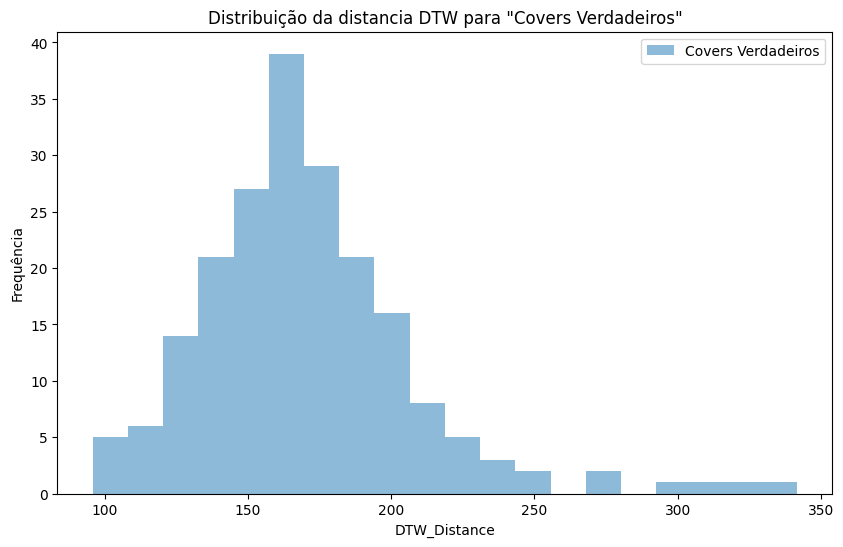

In [57]:
plt.figure(figsize=(10, 6))

plt.hist(true_covers['DTW_Distance'],
         bins=20, alpha=0.5, label='Covers Verdadeiros')

plt.xlabel('DTW_Distance')
plt.ylabel('Frequência')
plt.legend()
plt.title('Distribuição da distancia DTW para "Covers Verdadeiros"')
plt.show()

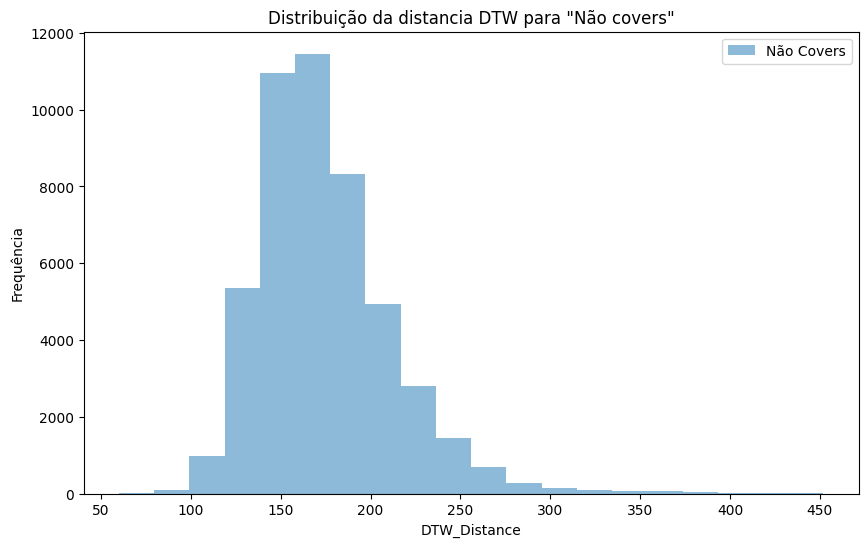

In [58]:
plt.figure(figsize=(10, 6))

plt.hist(false_covers['DTW_Distance'],
         bins=20, alpha=0.5, label='Não Covers')

plt.xlabel('DTW_Distance')
plt.ylabel('Frequência')
plt.legend()
plt.title('Distribuição da distancia DTW para "Não covers"')
plt.show()

## Escolha do Threshold

A escolha do threshold foi baseada na maximização do F1-score, que equilibra precisão e recall, garantindo um compromisso adequado entre falsos positivos e falsos negativos.

Para determinar o melhor valor, variamos o threshold entre os extremos dos valores de DTW_Distance e selecionamos aquele que apresentou o maior F1-score nos dados de validação.



In [59]:
# Gera uma sequência de thresholds entre o mínimo e o máximo dos valores de DTW_Distance
thresholds = np.linspace(df_valid['DTW_Distance'].min(), df_valid['DTW_Distance'].max(), num=100)

best_threshold = None
best_f1 = -1  # Inicializa com um valor muito baixo
resultados = []

for threshold in thresholds:
    # Predição: considera cover se DTW_Distance for menor que o threshold
    y_pred = df_valid['DTW_Distance'] < threshold

    precision = precision_score(df_valid['is_cover'], y_pred, zero_division=0)
    recall = recall_score(df_valid['is_cover'], y_pred, zero_division=0)
    f1 = f1_score(df_valid['is_cover'], y_pred, zero_division=0)

    resultados.append((threshold, precision, recall, f1))

    # Verifica se o F1 atual é melhor que o melhor encontrado até o momento
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Melhor threshold: {best_threshold}")
print(f"Melhor F1-Score: {best_f1}")

Melhor threshold: 107.48719448550014
Melhor F1-Score: 0.019417475728155338


Com o melhor threshold definido, podemos calcular as outras métricas de qualidade para o algoritmo.

In [60]:
threshold = 107.48719448550014

# Classifica como cover se a distância for menor que o threshold
df_valid['predicted_cover'] = df_valid['DTW_Distance'] < threshold

y_true = df_valid['is_cover']
y_pred = df_valid['predicted_cover']

print("Acurácia:", accuracy_score(y_true, y_pred))
print("Precisão:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred))
print("Matriz de confusão:\n", confusion_matrix(y_true, y_pred))

Acurácia: 0.9894697333027503
Precisão: 0.01597444089456869
Recall: 0.024752475247524754
F1-score: 0.019417475728155338
Matriz de confusão:
 [[47447   308]
 [  197     5]]


Além disso, vamos exibir a curva ROC (Receiver Operating Characteristic) que mostra como a taxa de verdadeiros positivos se relaciona com a taxa de falsos positivos para diferentes valores de limiar.

AUC: 0.5307151498313898


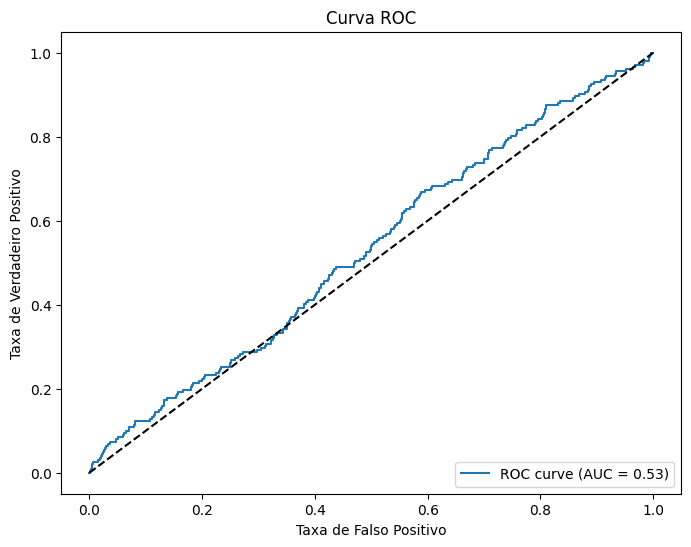

In [62]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Converte os rótulos para 0 e 1 (True -> 1, False -> 0)
y_true = df_valid['is_cover'].astype(int)
# Inverte o score: quanto menor a distância, maior a chance de ser cover
scores = -df_valid['DTW_Distance']

fpr, tpr, thresholds = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Agora geramos informações sobre os resultados para ajudar na análise do artigo.

Estatísticas dos Covers Verdadeiros:
count    202.000000
mean     170.613371
std       37.694305
min       95.754694
25%      147.835491
50%      166.245221
75%      187.972685
max      341.746610
Name: DTW_Distance, dtype: float64

Estatísticas dos Covers Não Verdadeiros:
count    47755.000000
mean       174.509385
std         37.204074
min         59.967662
25%        148.928816
50%        168.647169
75%        193.377394
max        452.003802
Name: DTW_Distance, dtype: float64


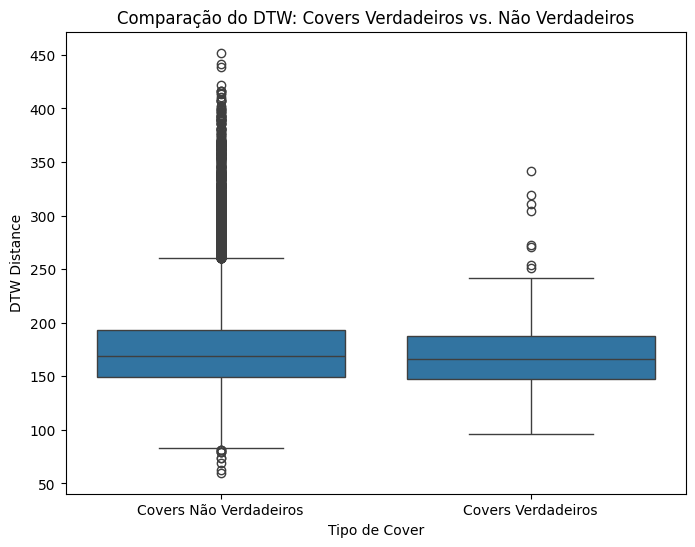

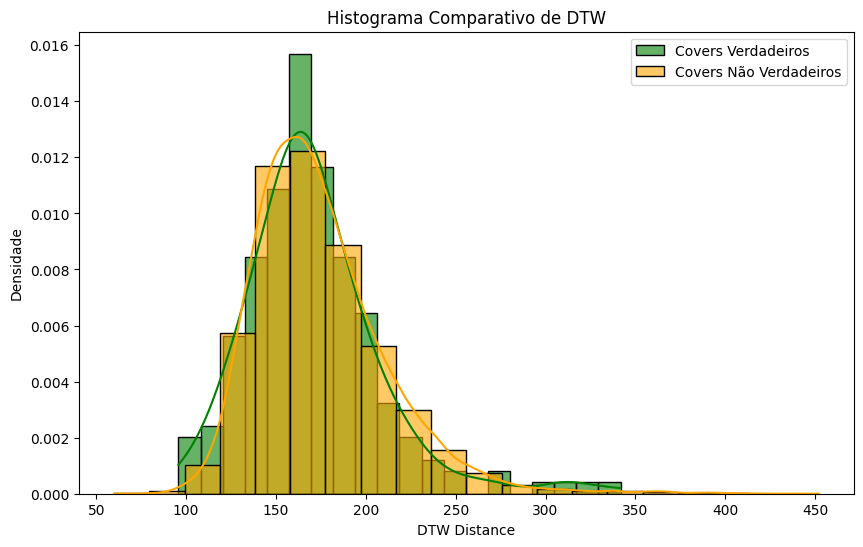

In [61]:
# Filtra apenas as linhas que possuem ground truth (não nulas)
df_valid = df_results[df_results['is_cover'].notnull()]

# 1. Estatísticas descritivas
print("Estatísticas dos Covers Verdadeiros:")
print(true_covers['DTW_Distance'].describe())

print("\nEstatísticas dos Covers Não Verdadeiros:")
print(false_covers['DTW_Distance'].describe())

# 2. Visualização com Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_cover', y='DTW_Distance', data=df_valid)
plt.xticks([0, 1], ['Covers Não Verdadeiros', 'Covers Verdadeiros'])
plt.title('Comparação do DTW: Covers Verdadeiros vs. Não Verdadeiros')
plt.xlabel('Tipo de Cover')
plt.ylabel('DTW Distance')
plt.show()

# 3. Visualização com Histogramas
plt.figure(figsize=(10, 6))
sns.histplot(true_covers['DTW_Distance'], bins=20, color='green', label='Covers Verdadeiros',
             kde=True, stat='density', alpha=0.6)
sns.histplot(false_covers['DTW_Distance'], bins=20, color='orange', label='Covers Não Verdadeiros',
             kde=True, stat='density', alpha=0.6)
plt.xlabel('DTW Distance')
plt.ylabel('Densidade')
plt.legend()
plt.title('Histograma Comparativo de DTW')
plt.show()

## Análise Manual

Para cada música que possui um cover, vamos exibir as ditâncias DTW para cada um de seus covers.

In [63]:
# Filtra as linhas de covers verdadeiros
true_covers = df_results[df_results['is_cover'] == True]

# Para cada grupo (música original), cria uma lista de dicionários com o cover e seu DTW
def listar_cover_dtw(grupo):
    return grupo[['Cover', 'DTW_Distance']].to_dict(orient='records')

covers_por_musica = true_covers.groupby('Original').apply(listar_cover_dtw).to_dict()

# Exibe o resultado
for original, covers in covers_por_musica.items():
    print(f"Música: {original}")
    for item in covers:
        print(f"  Cover: {item['Cover']} - DTW: {item['DTW_Distance']}")
    print("\n")


Música: 01 The Beatles - A Hard Day_s Night.flac.npy
  Cover: Peggy Lee - A hard days night [mUBAGLinKfI].mp4.npy - DTW: 175.1785925651055
  Cover: Mando Diao A Hard Days Night [ukZJJHslm40].mp4.npy - DTW: 157.35092482380398
  Cover: Katja Ebstein - A Hard Days Night [tD7vFn33ul8].mp4.npy - DTW: 191.9129809589981
  Cover: A Hard Day's Night  Otis Redding [OO-SAflX0qI].mp4.npy - DTW: 174.97617840441697


Música: 01 The Beatles - Drive My Car.flac.npy
  Cover: Humble Pie-Drive My Car (The Beatles cover) [zXBG73TnEZQ].mp4.npy - DTW: 202.0019037410198
  Cover: Kip Winger - Drive My Car [AOa2VulaQsM].mp4.npy - DTW: 168.79189603340052
  Cover: Melissa Etheridge, etc. - Drive My Car (Beatles Cover) [i2WuKU8LuUY].mp4.npy - DTW: 153.29635994812983


Música: 01 The Beatles - Help!.flac.npy
  Cover: Deep Purple - Help (Beatles Cover) Denmark 1968 HD [WBugcmKpO2o].mp4.npy - DTW: 142.9908622592315
  Cover: Kylie Minogue - Help (John Lennon Tribute Concert 1990) [aqOluhXOzWs].mp4.npy - DTW: 199.9655

<ipython-input-63-da12bb53b65d>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  covers_por_musica = true_covers.groupby('Original').apply(listar_cover_dtw).to_dict()


Por fim, escolhemos uma música de exemplo e exibimos todos os resultados do DTW para "Covers Verdadeiros" e "Não Covers".

In [64]:
musica = "03 The Beatles - Paperback Writer.flac.npy"

Filtra os registros da música selecionada e separa os covers para essa música.

In [65]:
df_musica = df_results[df_results['Original'] == musica]

if df_musica.empty:
    print(f"Não há registros para a música: {musica}")
else:
    covers_true = df_musica[df_musica['is_cover'] == True]
    covers_false = df_musica[df_musica['is_cover'] == False]

In [66]:
print(f"Análise para a música: {musica}\n")

print("Covers Verdadeiros:")
for _, row in covers_true.iterrows():
  print(f"  Cover: {row['Cover']} - DTW: {row['DTW_Distance']}")

print("\nCovers Não Verdadeiros:")
for _, row in covers_false.iterrows():
  print(f"  Cover: {row['Cover']} - DTW: {row['DTW_Distance']}")

Análise para a música: 03 The Beatles - Paperback Writer.flac.npy

Covers Verdadeiros:
  Cover: Sweet - Paperback Writer (BBC Session) [nDqOr6NTqOY].mp4.npy - DTW: 131.58149762861748
  Cover: 10CC - Paperback Writer [AiHmMEUK5EQ].mp4.npy - DTW: 154.73756332324558
  Cover: Paperback Writer - The Octopussy's Garden and Its Freaky Animals [UaiAQo6J3ik].mp4.npy - DTW: 166.3109027586263
  Cover: ＂Paperback Writer＂ - The Strangers (1965) [CCWmbxoK5mA].mp4.npy - DTW: 150.33880758437726
  Cover: The Shadows ＂Paperback Writer＂ [9E35SUliHgU].mp4.npy - DTW: 196.6665659364342
  Cover: the B-52's Paperback Writer - The Beatles cover [qCdHW9tULHM].mp4.npy - DTW: 156.3721970655904

Covers Não Verdadeiros:
  Cover: Please Mister Postman - The Beatles cover [QCTwUTyQYJs].mp4.npy - DTW: 173.7173639998876
  Cover: Robert Gordon - Run For Your Life (The Beatles Cover) [sfkycayQ_OE].mp4.npy - DTW: 274.32333476904086
  Cover: heather nova we can work it out [VUunSZkaVgU].mp4.npy - DTW: 157.2607641389806
  C